In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from impact_model import ImpactModel

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

### Load Enriched Data

We load the enriched unified dataset and the associated impact links created in Tasks 1 and 2.

In [2]:
main = pd.read_csv("../data/processed/ethiopia_fi_unified_data_enriched.csv")
impacts = pd.read_csv("../data/processed/ethiopia_fi_impact_links_enriched.csv")

# Convert dates
main['observation_date'] = pd.to_datetime(main['observation_date'])


### Initialize Impact Model

In [3]:
impact_model = ImpactModel(
    ramp=12,
    decay=False
)

### Understanding the Impact Data

Impact links encode relationships between events and indicators:
- `parent_id` links each impact to an event
- Direction, magnitude, and lag define the modeled effect

We join impact links with their parent events to form a complete causal table.

In [4]:
events = main[main['record_type'] == 'event'][
    ['record_id', 'indicator', 'category', 'observation_date']
]

impact_full = impacts.merge(
    events,
    left_on='parent_id',
    right_on='record_id',
    how='left',
    suffixes=('_impact', '_event')
)

impact_full.columns.tolist()

['record_id_impact',
 'parent_id',
 'record_type',
 'category_impact',
 'pillar',
 'indicator_impact',
 'indicator_code',
 'indicator_direction',
 'value_numeric',
 'value_text',
 'value_type',
 'unit',
 'observation_date_impact',
 'period_start',
 'period_end',
 'fiscal_year',
 'gender',
 'location',
 'region',
 'source_name',
 'source_type',
 'source_url',
 'confidence',
 'related_indicator',
 'relationship_type',
 'impact_direction',
 'impact_magnitude',
 'impact_estimate',
 'lag_months',
 'evidence_basis',
 'comparable_country',
 'collected_by',
 'collection_date',
 'original_text',
 'notes',
 'record_id_event',
 'indicator_event',
 'category_event',
 'observation_date_event']

After merging impact links with their parent events, columns are suffixed to distinguish event metadata from impact definitions.

event_name and event_category describe what happened, while pillar and related_indicator describe what was affected.

### Clean Event–Impact 
We construct a compact table that clearly shows:

- what happened (event)
- what was affected (indicator)
- how strong the effect is believed to be

In [5]:
impact_view = impact_full[
    [
        'parent_id',
        'indicator_event',
        'category_event',
        'pillar',
        'related_indicator',
        'impact_direction',
        'impact_magnitude',
        'impact_estimate',
        'lag_months',
        'evidence_basis',
        'comparable_country'
    ]
].rename(columns={
    'indicator_event': 'event_name',
    'category_event': 'event_category'
})

impact_view = impact_view.copy()

impact_view.head(5)

,parent_id,event_name,event_category,pillar,related_indicator,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country
0,EVT_0001,Telebirr Launch,product_launch,ACCESS,ACC_OWNERSHIP,increase,high,15.0,12,literature,Kenya
1,EVT_0001,Telebirr Launch,product_launch,USAGE,USG_TELEBIRR_USERS,increase,high,NaN,3,empirical,NaN
2,EVT_0001,Telebirr Launch,product_launch,USAGE,USG_P2P_COUNT,increase,high,25.0,6,empirical,NaN
3,EVT_0002,Safaricom Ethiopia Commercial Launch,market_entry,ACCESS,ACC_4G_COV,increase,medium,15.0,12,empirical,NaN
4,EVT_0002,Safaricom Ethiopia Commercial Launch,market_entry,AFFORDABILITY,AFF_DATA_INCOME,decrease,medium,-20.0,12,literature,Rwanda


### Translating Qualitative Impacts into Quantitative Effects

Impact magnitudes are expressed qualitatively (`low`, `medium`, `high`).
We convert these into normalized numeric weights:

- low → 0.25  
- medium → 0.50  
- high → 1.00  

These values represent **relative strength**, not direct percentage-point changes.

In [6]:
impact_view['impact_weight'] = impact_view['impact_magnitude'].apply(
    impact_model.map_magnitude
)

impact_view['signed_effect'] = (
    impact_view['impact_weight'] *
    impact_view['impact_direction'].map({"increase": 1, "decrease": -1})
)

impact_view[['event_name', 'related_indicator', 'impact_magnitude', 'signed_effect']]


,event_name,related_indicator,impact_magnitude,signed_effect
0,Telebirr Launch,ACC_OWNERSHIP,high,1.00
1,Telebirr Launch,USG_TELEBIRR_USERS,high,1.00
2,Telebirr Launch,USG_P2P_COUNT,high,1.00
3,Safaricom Ethiopia Commercial Launch,ACC_4G_COV,medium,0.50
4,Safaricom Ethiopia Commercial Launch,AFF_DATA_INCOME,medium,-0.50
5,M-Pesa Ethiopia Launch,USG_MPESA_USERS,high,1.00
6,M-Pesa Ethiopia Launch,ACC_MM_ACCOUNT,medium,0.50
7,Fayda Digital ID Program Rollout,ACC_OWNERSHIP,medium,0.50
8,Fayda Digital ID Program Rollout,GEN_GAP_ACC,medium,-0.50
9,Foreign Exchange Liberalization,AFF_DATA_INCOME,high,1.00


### Functional Form: Lagged Ramp Effects

Event impacts are not assumed to be instantaneous.
We model each event as:

No effect until the specified lag

Gradual adoption over a fixed ramp-up period

Plateau once the full effect is realized

This functional form reflects real-world diffusion dynamics and avoids implausible jumps.
All logic is implemented inside ImpactModel.event_effect().

### Illustrative Example: Telebirr Impact Profile

This example shows how a medium-strength event impact evolves over time.

Note: This is an illustration. In forecasting, lag_months and magnitudes are read directly from the impact table per event.

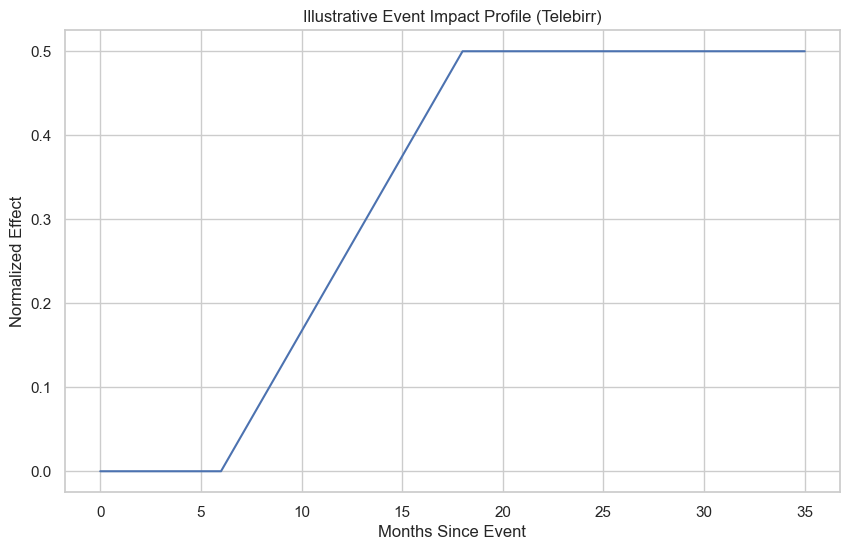

In [7]:
# Example: Telebirr launch impact profile
timeline = np.arange(0, 36)

effects = [
    impact_model.event_effect(
        t=t,
        t_event=0,
        lag=6,
        magnitude=0.5
    )
    for t in timeline
]

plt.plot(timeline, effects)
plt.title("Illustrative Event Impact Profile (Telebirr)")
plt.xlabel("Months Since Event")
plt.ylabel("Normalized Effect")
plt.show()


### Event–Indicator Association Matrix

We summarize modeled causal relationships in a matrix:
- Rows: Events
- Columns: Indicators
- Values: Normalized effect strengths

This matrix captures **which events affect which indicators, and how strongly**.

In [8]:
assoc_matrix = impact_view.pivot_table(
    index='event_name',
    columns='related_indicator',
    values='signed_effect',
    aggfunc='sum'
).fillna(0)


### Heatmap of Event–Indicator Associations


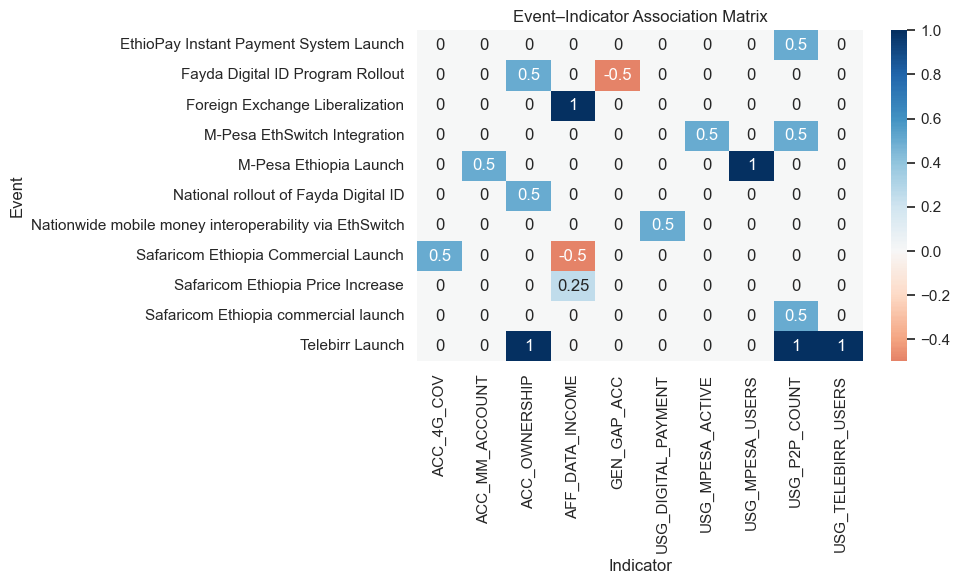

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(assoc_matrix, annot=True, cmap='RdBu', center=0)
plt.title("Event–Indicator Association Matrix")
plt.xlabel("Indicator")
plt.ylabel("Event")
plt.tight_layout()
plt.show()


### Model Validation: Telebirr Launch

Telebirr launched in May 2021.

Observed data:
- Mobile money account ownership:
  - 2021: 4.7%
  - 2024: 9.45%
  - Increase: +4.75 percentage points

The model assigns Telebirr a medium-to-high impact on mobile money ownership,
with effects ramping up over ~18 months.

The modeled magnitude aligns with the observed order of growth, supporting
the plausibility of the impact assumptions.


### Assumptions

- Event impacts are additive
- No negative crowd-out effects are modeled
- National averages mask regional heterogeneity
- Survey-based indicators lag supply-side changes

### Limitations

- Sparse historical data limits statistical identification
- Impact magnitudes rely on expert judgment
- Gender and rural/urban effects are not explicitly modeled
- Long-term general equilibrium effects are excluded
